In [1]:
import sys, os, glob
sys.path.append('/home/gddaslab/mxp140/tcr_project_ultimate')
from constants import patient_names, max_kr_panpep, max_kr_vdjdb, max_kr_mcpas
from pdf import pdf as pdf

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind, pearsonr, linregress

In [3]:
asterisk = '\u2217'
p_value_stars = {0.001: f'{asterisk}{asterisk}{asterisk}', 0.01: f'{asterisk}{asterisk}', 0.05: f'{asterisk}'}
def get_asterisks(p_value):
    for threshold in sorted(p_value_stars.keys()):
        if p_value < threshold:
            return p_value_stars[threshold]
    return 'ns'

In [4]:
pooled_data_filename_for_panpep = "/home/gddaslab/mxp140/tcr_project_ultimate/data/BrMET_and_GBM_data-PANPEP.csv"
pooled_data_filename_for_ergo2 = "/home/gddaslab/mxp140/tcr_project_ultimate/data/BrMET_and_GBM_data-ERGOII.csv"
find_regionwise_data_filename_for_panpep_in = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP"
find_regionwise_data_filename_for_ergo2_in = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII"

/tmp/ipykernel_2557643/4125707056.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resulting_df = pd.concat([resulting_df, region_df], axis=0, ignore_index=True)


Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.
So, `None` values are added for ERGOII to match the shape of the df_melted. Ignore NaNs when plotting for ERGOII.


/tmp/ipykernel_2557643/4125707056.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_region_labels, rotation=90)


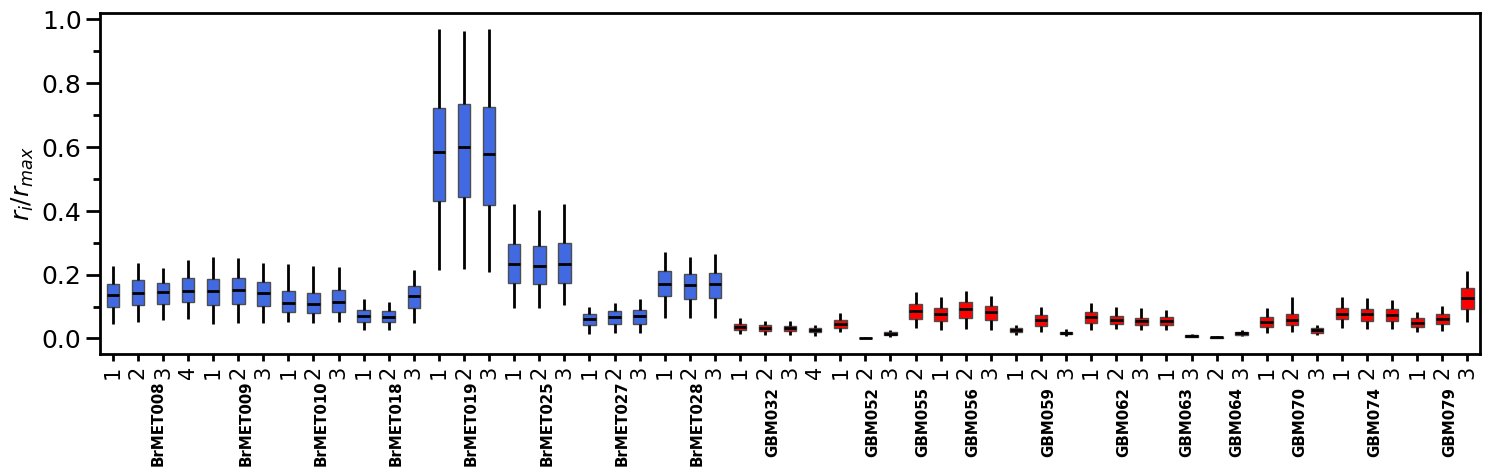

/tmp/ipykernel_2557643/4125707056.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_region_labels, rotation=90)


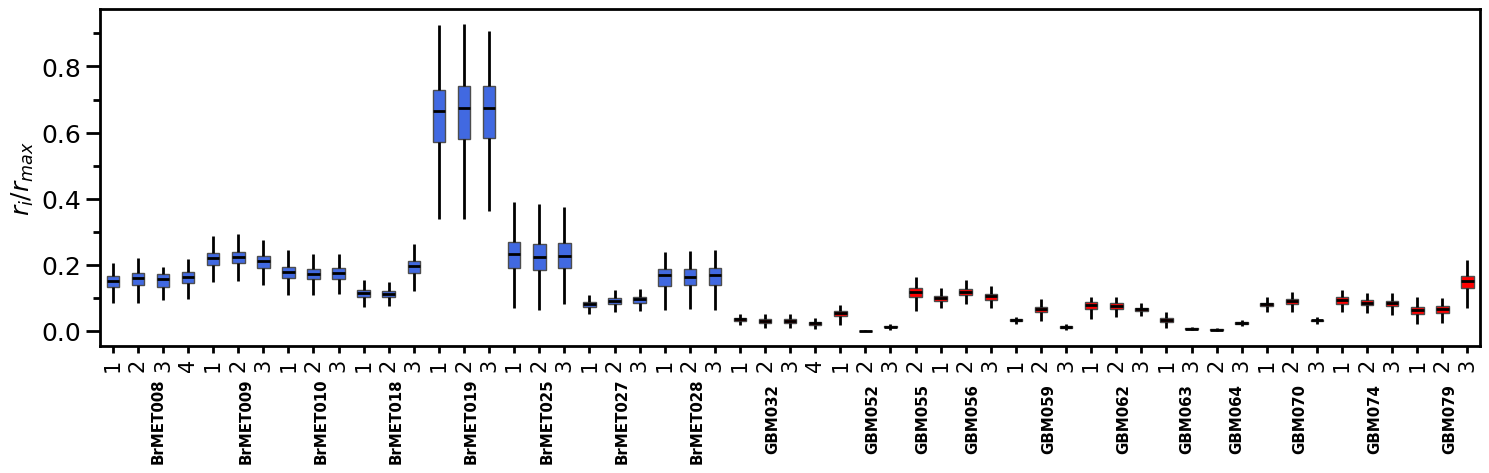

/tmp/ipykernel_2557643/4125707056.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_region_labels, rotation=90)


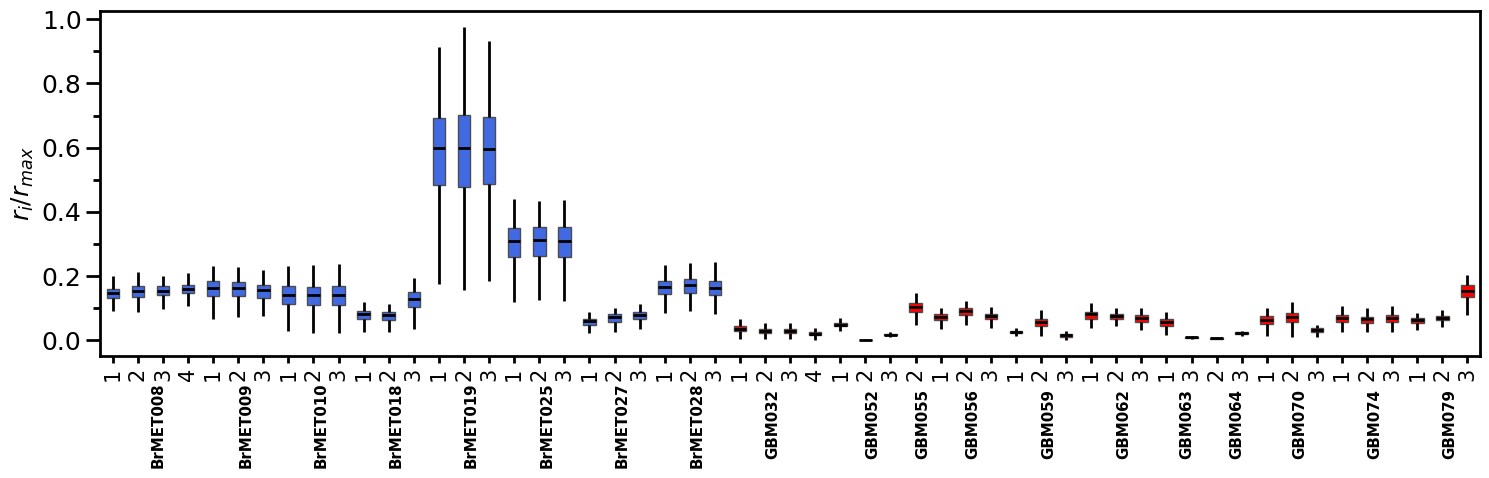

In [5]:
def fig2b():
    resulting_df = pd.DataFrame(columns=['patient', 'panpep', 'vdjdb', 'mcpas', 'GBM'])
    for patient_id in patient_names:
        filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
        filepath_format_for_ergo2 = os.path.join(find_regionwise_data_filename_for_ergo2_in, patient_id, f"{patient_id}_region*.csv")
        
        full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
        full_filepath_for_ergo2 = glob.glob(filepath_format_for_ergo2)
        
        sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
        sorted_by_region_full_filepath_for_ergo2 = sorted(full_filepath_for_ergo2, key=lambda x: int(x.split("region")[1].split(".")[0]))
        
        for file_panpep, file_ergo2 in zip(sorted_by_region_full_filepath_for_panpep, sorted_by_region_full_filepath_for_ergo2):
            region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
            region_number_ergo2 = int(file_ergo2.split("region")[1].split(".")[0])
            # print(region_number_panpep, region_number_ergo2)
            if region_number_panpep == region_number_ergo2:
                kr_values_panpep = pd.read_csv(file_panpep, sep=',')['kr'].values
                kr_values_vdjdb = pd.read_csv(file_ergo2, sep=',')['kr_vdjdb'].values
                kr_values_mcpas = pd.read_csv(file_ergo2, sep=',')['kr_mcpas'].values
                
                len_kr_panpep = kr_values_panpep.shape[0]
                len_kr_vdjdb = kr_values_vdjdb.shape[0]
                len_kr_mcpas = kr_values_mcpas.shape[0]
                max_len = max(len_kr_panpep, len_kr_vdjdb, len_kr_mcpas)
                # print(len_kr_panpep, len_kr_vdjdb, max_len)
                region_df = pd.DataFrame({'patient':patient_id + '-' + str(region_number_panpep),
                                        'panpep':list(kr_values_panpep/max_kr_panpep),
                                        'vdjdb':list(kr_values_vdjdb/max_kr_vdjdb) + [None]*(max_len-len_kr_vdjdb),
                                        'mcpas':list(kr_values_mcpas/max_kr_mcpas) + [None]*(max_len - len_kr_mcpas),
                                        'GBM': True if 'GBM' in patient_id else False})
                resulting_df = pd.concat([resulting_df, region_df], axis=0, ignore_index=True)
            else:
                raise ValueError('The region numbers do not match.')
    print('Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.\nSo, `None` values are added for ERGOII to match the shape of the df_melted. Ignore NaNs when plotting for ERGOII.')
    # print(resulting_df.head())
    # print(resulting_df.shape)
    
    for i, kr_type in enumerate(['panpep', 'vdjdb', 'mcpas']):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
        sns.boxplot(
            data=resulting_df,
            x="patient",
            y=kr_type,
            hue="GBM",
            ax=ax,
            palette={False: 'royalblue', True: 'red'},
            medianprops={"color": "black", "linewidth": 2},
            whiskerprops={"color": "black", "linewidth": 2},
            width = 0.5,
            capprops={"color":"none"},
            showfliers=False,
            legend=False,
            fill=True,
            dodge=False,
            saturation=1.0
            )
        ax.grid(False)
        ax.set_ylabel(r'$r_i$/$r_{max}$', fontsize=18)
        ax.set_xlabel('')
        
        new_region_labels = [label.split('-')[1] for label in resulting_df['patient'].unique()]
        ax.set_xticklabels(new_region_labels, rotation=90)
        patient_labels = np.unique([label.split('-')[0] for label in resulting_df['patient'].unique()])
        # Add text labels for each patient: there ar 19 patients. Manually input xtick position for 19 labels. That is teh easiest
        patient_label_pos = [1.5, 5, 8, 11, 14, 17, 20, 23, 26, 30, 32, 34, 37, 40, 42.5, 44.5, 47, 50, 53]
        for patient, label_pos in zip(patient_labels, patient_label_pos):
            y_pos = (np.min(ax.get_yticks())-0.19 if 'BrMET' in patient else np.min(ax.get_yticks())-0.161)
            ax.text(label_pos, y_pos, patient, rotation='vertical', stretch='ultra-condensed', horizontalalignment='left', fontsize='large', color='black', weight='semibold')
        
        ax.annotate('', xy=(3, -0.4), xytext=(0, -0.4), arrowprops=dict(facecolor='black'),)
        
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
        for label in ax.get_yticklabels():
            label.set_fontsize(18)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
        ax.tick_params(
            axis="x", which="major", direction="out", length=5, width=2, labelsize=15
        )
        # ax.tick_params(
        #     axis="x", which="minor", direction="out", length=5, width=2, labelsize=18
        # )
        ax.tick_params(
            axis="y", which="major", direction="out", length=10, width=2, labelsize=18
        )
        ax.tick_params(
            axis="y", which="minor", direction="out", length=5, width=2, labelsize=18
        )
        
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        
        plt.tight_layout()
        plt.savefig(f'fig2b-{kr_type}.png', format='png', bbox_inches='tight', dpi=320)
        plt.show()
a = fig2b()

/tmp/ipykernel_2557643/2797672988.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resulting_df = pd.concat([resulting_df, region_df], ignore_index=True)


Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.
So, `None` values are added for ERGOII to match the shape of the resulting_df. Ignore NaNs when plotting for ERGOII.


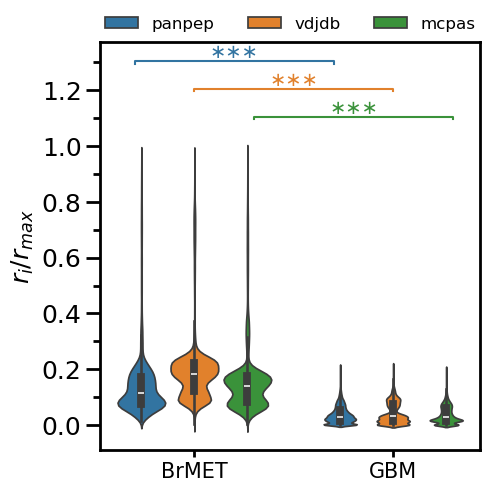

In [6]:
def fig2c():
    resulting_df = pd.DataFrame(columns=['patient', 'panpep', 'vdjdb', 'mcpas'])
    for patient_id in patient_names:
        filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
        filepath_format_for_ergo2 = os.path.join(find_regionwise_data_filename_for_ergo2_in, patient_id, f"{patient_id}_region*.csv")
        
        full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
        full_filepath_for_ergo2 = glob.glob(filepath_format_for_ergo2)
        
        sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
        sorted_by_region_full_filepath_for_ergo2 = sorted(full_filepath_for_ergo2, key=lambda x: int(x.split("region")[1].split(".")[0]))
        
        for file_panpep, file_ergo2 in zip(sorted_by_region_full_filepath_for_panpep, sorted_by_region_full_filepath_for_ergo2):
            region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
            region_number_ergo2 = int(file_ergo2.split("region")[1].split(".")[0])
            
            if region_number_panpep == region_number_ergo2:
                kr_values_panpep = pd.read_csv(file_panpep, sep=',')['kr'].values
                kr_values_vdjdb = pd.read_csv(file_ergo2, sep=',')['kr_vdjdb'].values
                kr_values_mcpas = pd.read_csv(file_ergo2, sep=',')['kr_mcpas'].values
                
                len_kr_panpep = kr_values_panpep.shape[0]
                len_kr_vdjdb = kr_values_vdjdb.shape[0]
                len_kr_mcpas = kr_values_mcpas.shape[0]
                max_len = max(len_kr_panpep, len_kr_vdjdb, len_kr_mcpas)
                # print(len_kr_panpep, len_kr_vdjdb, max_len)
                region_df = pd.DataFrame({'patient':'BrMET' if 'BrMET' in patient_id else 'GBM',
                                            'panpep':kr_values_panpep/max_kr_panpep,
                                            'vdjdb':list(kr_values_vdjdb/max_kr_vdjdb) + [None]*(max_len-len_kr_vdjdb),
                                            'mcpas':list(kr_values_mcpas/max_kr_mcpas) + [None]*(max_len - len_kr_mcpas)})
                resulting_df = pd.concat([resulting_df, region_df], ignore_index=True)
            else:
                raise ValueError('The region numbers do not match.')
    print('Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.\nSo, `None` values are added for ERGOII to match the shape of the resulting_df. Ignore NaNs when plotting for ERGOII.')
    # print(resulting_df.head())
    # print(resulting_df.shape)
    
    # Melt the DataFrame to long format
    df_melted = resulting_df.melt(id_vars='patient', value_vars=['panpep', 'vdjdb', 'mcpas'], var_name='type', value_name='value')
    df_melted = df_melted.dropna(axis=0)
    # print(df_melted)

    p_value_panpep = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='panpep')]['value'].values, 
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='panpep')]['value'].values, equal_var=False).pvalue
    p_value_vdjdb = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='vdjdb')]['value'].values, 
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='vdjdb')]['value'].values, equal_var=False).pvalue
    p_value_mcpas = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='mcpas')]['value'].values,
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='mcpas')]['value'].values, equal_var=False).pvalue
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    violinplot = sns.violinplot(x='patient', y='value', hue='type', data=df_melted, ax=ax, inner='box', width=0.8, density_norm='count', gap=0.1)
    ax.grid(False)    
    
    x1s = [-0.3, 0, 0.3]
    x2s = [0.7, 1.0, 1.3]
    ys= [1.3, 1.2, 1.1]
    hs = [0.01, 0.01, 0.01]
    colors = [patch.get_facecolor() for patch in violinplot.patches]
    for x1, x2, y, h, color in zip(x1s, x2s, ys, hs, colors):
        ax.plot([x1, x1, x2, x2], [y - h / 2, y + h / 2, y + h / 2, y - h / 2], lw=1.5, c=color)
        ax.text((x1 + x2) * .5, y + h * 0.1, f'{get_asterisks(p_value_panpep)}', ha='center', va='bottom', color=color, fontsize=14)
    
    ax.set_ylabel(r'$r_i$/$r_{max}$', fontsize=18)
    ax.set_xlabel('')
    
    for label in ax.get_xticklabels():
        label.set_fontsize(14)
    for label in ax.get_yticklabels():
        label.set_fontsize(18)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.tick_params(
        axis="x", which="major", direction="out", length=5, width=2, labelsize=15
    )
    ax.tick_params(
        axis="y", which="major", direction="out", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="out", length=5, width=2, labelsize=18
    )
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.10),
        ncol=3,
        fontsize=12,
        frameon=False
    )
    
    plt.tight_layout()
    plt.savefig('fig2c.png', format='png', bbox_inches='tight', dpi=320)
    plt.show()
fig2c()

/tmp/ipykernel_2557643/2731473626.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resulting_df = pd.concat([resulting_df, region_df], ignore_index=True)


Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.
So, `None` values are added for ERGOII to match the shape of the resulting_df. Ignore NaNs when plotting for ERGOII.


/tmp/ipykernel_2557643/2731473626.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


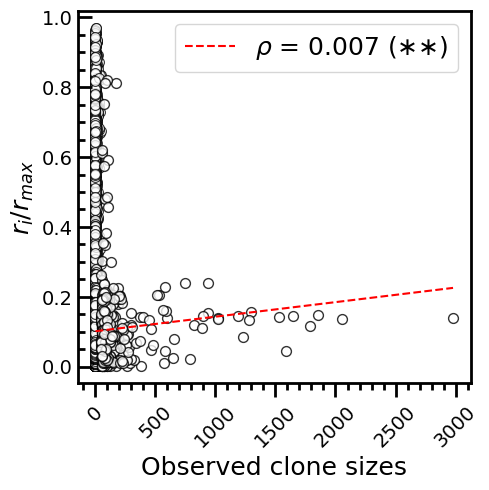

/tmp/ipykernel_2557643/2731473626.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


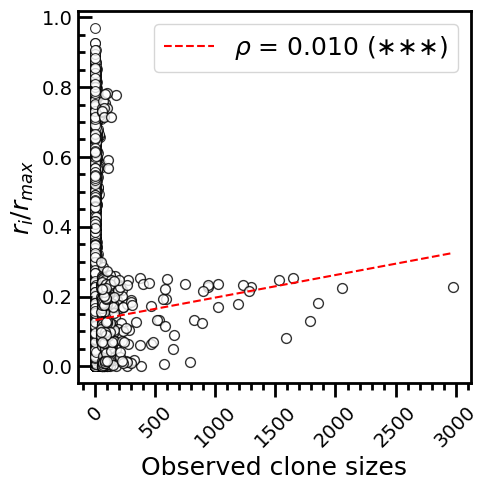

/tmp/ipykernel_2557643/2731473626.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


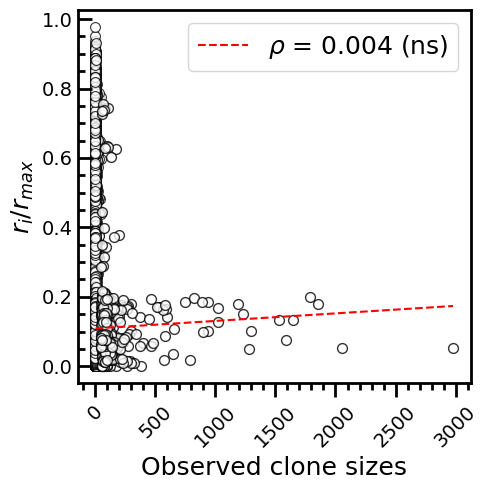

In [11]:
def fig2d():
    resulting_df = pd.DataFrame(columns=['panpep', 'vdjdb', 'mcpas', 'counts_panpep', 'counts_vdjdb', 'counts_mcpas'])
    for patient_id in patient_names:
        filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
        filepath_format_for_ergo2 = os.path.join(find_regionwise_data_filename_for_ergo2_in, patient_id, f"{patient_id}_region*.csv")
        
        full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
        full_filepath_for_ergo2 = glob.glob(filepath_format_for_ergo2)
        
        sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
        sorted_by_region_full_filepath_for_ergo2 = sorted(full_filepath_for_ergo2, key=lambda x: int(x.split("region")[1].split(".")[0]))
        
        for file_panpep, file_ergo2 in zip(sorted_by_region_full_filepath_for_panpep, sorted_by_region_full_filepath_for_ergo2):
            region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
            region_number_ergo2 = int(file_ergo2.split("region")[1].split(".")[0])
            
            if region_number_panpep == region_number_ergo2:
                kr_values_panpep = pd.read_csv(file_panpep, sep=',')['kr'].values
                kr_values_vdjdb = pd.read_csv(file_ergo2, sep=',')['kr_vdjdb'].values
                kr_values_mcpas = pd.read_csv(file_ergo2, sep=',')['kr_mcpas'].values
                
                counts_panpep = pd.read_csv(file_panpep, sep=',')['counts'].values
                counts_vdjdb = pd.read_csv(file_ergo2, sep=',')['counts'].values
                counts_mcpas = pd.read_csv(file_ergo2, sep=',')['counts'].values
                
                len_kr_panpep = kr_values_panpep.shape[0]
                len_kr_vdjdb = kr_values_vdjdb.shape[0]
                len_kr_mcpas = kr_values_mcpas.shape[0]
                max_len = max(len_kr_panpep, len_kr_vdjdb, len_kr_mcpas)
                # print(len_kr_panpep, len_kr_vdjdb, max_len)
                
                region_df = pd.DataFrame({'panpep':kr_values_panpep/max_kr_panpep,
                                          'vdjdb':list(kr_values_vdjdb/max_kr_vdjdb) + [None]*(max_len-len_kr_vdjdb),
                                          'mcpas':list(kr_values_mcpas/max_kr_mcpas) + [None]*(max_len - len_kr_mcpas),
                                          'counts_panpep':counts_panpep,
                                          'counts_vdjdb':list(counts_vdjdb) + [None]*(max_len-len_kr_vdjdb),
                                          'counts_mcpas':list(counts_mcpas) + [None]*(max_len-len_kr_mcpas)})
                resulting_df = pd.concat([resulting_df, region_df], ignore_index=True)
            else:
                raise ValueError('The region numbers do not match.')
    print('Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.\nSo, `None` values are added for ERGOII to match the shape of the resulting_df. Ignore NaNs when plotting for ERGOII.')
    # print(resulting_df.head())
    # print(resulting_df.shape)
    
    # Melt the DataFrame to long format
    df_melted = resulting_df.melt(id_vars=['counts_panpep', 'counts_vdjdb', 'counts_mcpas'], value_vars=['panpep', 'vdjdb', 'mcpas'], var_name='type', value_name='value')
    df_melted['counts'] = df_melted.apply(lambda row: row['counts_panpep'] if row['type'] == 'panpep' else (row['counts_vdjdb'] if row['type'] == 'vdjdb' else row['counts_mcpas']), axis=1)
    # Drop the original counts columns
    df_melted = df_melted.drop(columns=['counts_panpep', 'counts_vdjdb', 'counts_mcpas'])
    df_melted = df_melted.dropna(axis=0)
    
    for kr_type in ['panpep', 'vdjdb', 'mcpas']:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        df = df_melted[df_melted['type']==kr_type]
        # # Plot points with counts < 10
        mask1 = (df['counts'] < 50)
        ax.scatter(df['counts'][mask1], df['value'][mask1], s=50.0, facecolors='white', edgecolors='black', alpha=0.8, linewidth=0.8)

        # # # Plot the remaining points
        mask3 = (df['counts'] >= 50)
        ax.scatter(df['counts'][mask3], df['value'][mask3], s=50.0, facecolors='white', edgecolors='black', alpha=0.8, linewidth=1)
        # ax.scatter(df_melted['counts'], df_melted['value'], s=50.0, facecolors='white', edgecolors='black', alpha=0.3)
        
        ax.grid(False)
        ax.set_xlabel(r'Observed clone sizes', fontsize=18)
        ax.set_ylabel(r'$r_i$/$r_{max}$', fontsize=18)
        
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
        for label in ax.get_yticklabels():
            label.set_fontsize(18)
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
        
        ax.tick_params(
            axis="x", which="major", direction="out", length=10, width=2, labelsize=14
        )
        ax.tick_params(
            axis="x", which="minor", direction="out", length=5, width=2, labelsize=14
        )
        ax.tick_params(
            axis="y", which="major", direction="in", length=10, width=2, labelsize=14
        )
        ax.tick_params(
            axis="y", which="minor", direction="in", length=5, width=2, labelsize=14
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
        
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        
        # Calculate Pearson correlation coefficient and plot the regresssion line
        slope, intercept, r_value, p_value, _ = linregress(df['counts'], df['value'])
        x_vals = np.linspace(df['counts'].min(), df['counts'].max(), 1000)
        y_vals = slope*x_vals + intercept
        ax.plot(x_vals, y_vals, '--', color='red', label=fr'$\rho$ = {r_value:.3f} ({get_asterisks(p_value)})') # (which is a centered asterisk)
        ax.legend(loc='best', fontsize=18)
        
        plt.tight_layout()
        plt.savefig(f'fig2d-{kr_type}.png', format='png', bbox_inches='tight', dpi=320)
        plt.show()
    return df_melted
a = fig2d()